In [2]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [7]:
from langchain.chat_models import ChatOpenAI

# To control the randomness and creativity of the generated
# text by an LLM, use temperature = 0.0
chat = ChatOpenAI(temperature=0.0)

In [53]:
template_string = """
    {final_text}

    1. What are the major diagnoses in the above admission. 

    {format_instructions}
    """

In [54]:
from langchain.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template(template_string)

In [55]:
print(prompt_template.messages[0].prompt)
print(prompt_template.messages[0].prompt.input_variables)

input_variables=['final_text', 'format_instructions'] output_parser=None partial_variables={} template='\n    {final_text}\n\n    1. What are the major diagnoses in the above admission. \n\n    {format_instructions}\n    ' template_format='f-string' validate_template=True
['final_text', 'format_instructions']


In [115]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

diagnosis = ResponseSchema(name="Diagnosis",
                             description="List of diagnosis extracted from the patient note",
                             type="list")
icd10 = ResponseSchema(name="ICD10",
                            description="List of ICD10 code of the diagnosis, if a diagnosis does not have ICD10, put \"None\"",
                            type="list")
primary_diagnosis = ResponseSchema(name="Primary Diagnosis",
                                    description="List of whether the given diagnosis is the primary diagnosis",
                                    type="list")

response_schemas = [diagnosis, 
                    icd10,
                    primary_diagnosis]

In [117]:
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

In [118]:
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"Diagnosis": list  // List of diagnosis extracted from the patient note
	"ICD10": list  // List of ICD10 code of the diagnosis, if a diagnosis does not have ICD10, put "None"
	"Primary Diagnosis": list  // List of whether the given diagnosis is the primary diagnosis
}
```


In [125]:
prompt = ChatPromptTemplate.from_template(template=template_string)
messages = prompt.format_messages(final_text='Patient admitted with CHF and UTI. Has h/o YHCD', 
                                format_instructions=format_instructions)

In [126]:
response = chat(messages)
output_dict = output_parser.parse(response.content)

In [127]:
print(response.content)

```json
{
	"Diagnosis": ["CHF", "UTI", "YHCD"],
	"ICD10": ["I50.9", "N39.0", "None"],
	"Primary Diagnosis": [true, false, false]
}
```


In [128]:
pd.DataFrame(output_dict)

,Diagnosis,ICD10,Primary Diagnosis
0,CHF,I50.9,True
1,UTI,N39.0,False
2,YHCD,None,False


### Q and A

In [1]:
from IPython.display import display, Markdown
from agents import create_qa_agent

queries = ["40 year old with CHF, Type II DM brought after he was bit by Krait. Vital signs on arrival are stable. What is the initial assessment I have to do, also list labs to be done.",
    "21 year old with snake bite, patient is not breathing well on examination and has symptoms of paralysis. what are the medications to be given along with the doses?",
    "I'm doing the clotting test, and the blood is not clotting, what should I do",
    "What is the dose of epinephrine for ASV reaction?",
    "How should ASV be administered?"]

index = create_qa_agent('data/Snake Bite Order set.pdf')

for query in queries:

    print(f"\n{query}\n\nResponse:\n")

    response = index.query(query)
    display(Markdown(response))


40 year old with CHF, Type II DM brought after he was bit by Krait. Vital signs on arrival are stable. What is the initial assessment I have to do, also list labs to be done.

Response:



 The initial assessment should include a physical examination to look for bite/fang marks, symptoms such as paralysis, local tissue toxicity/necrosis, coagulopathy/hemorrhage, rhabdomyolysis, hypotension, acute kidney injury, and compartment syndrome. Labs to be done include CBC, BT, CT, PT, APTT, platelets, serum fibrinogen, FDP, D-dimer, LDH, peripheral smear, whole blood clotting test, urine for myoglobin, hemoglobin, urine microscopy for RBC, casts, RFT, urinary proteins, creatinine ratio, LFT, ECG and Echo if in shock, blood/urine/wound culture, ABG, single breath count, breath holding time, and anticholinesterase test.


21 year old with snake bite, patient is not breathing well on examination and has symptoms of paralysis. what are the medications to be given along with the doses?

Response:



 The patient should be given neostigmine 0.5-2.5 mg every 1-3 hours (max: 10 mg/day) + Atropine 0.6 mg Q12H intravenously or neostigmine 15 mg Q6H + Atropine 0.6 mg Q12h orally. Epinephrine 0.5 mg should be given every 5-10 minutes if needed, and if the patient has bronchospasm, inhaled SABA + anti-H1 blocker should be given.


I'm doing the clotting test, and the blood is not clotting, what should I do

Response:



 Repeat WBCT every 30 minutes for the first 3 hours - Repeat every hour for the next 3 hours - Repeat every 3 hours for the next 6 hours - If the patient is continuing to bleed briskly after 1-2 hours, repeat 10 vials of ASV.


What is the dose of epinephrine for ASV reaction?

Response:



 Epinephrine 0.5 mg → Repeat every 5-10 minutes if required.


How should ASV be administered?

Response:



 ASV should be administered over 1 hour through the IV route. The dose is 10 vials of ASV diluted in 250 ml of NS/5% Dextrose over 1 hour.

In [4]:
file = 'data/OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)

In [ ]:
# query ="What are the aliases of the lab Influenza virus A"
# query = "What is the lab name which has alias COVID PCR"
# query = "What is/are the most similar labs to the lab HEV-IgM Antibodies to Hepatitis E Virus?"
# query = "Which lab has loinc code of 32673-6"

In [52]:
import pandas as pd
df = pd.read_csv('data/labs.csv', index_col=0)

In [84]:
df[df.name.str.contains('Hep')]

,loinc,system,class,methodType,name,alias,fields,category,patientType,_id.$oid,__v
13,24324-6,Ser/Plas,PANEL.CHEM,NaN,Hepatic function 1996 panel,"['LFT', 'Liver Function Test', 'CMP', 'Complet...","[{'name': 'Albumin', 'alias': [], 'type': '', ...",labs,"['neonatal', 'adult', 'pediatric']",60ebea7c5311e98d7d526f0c,NaN
1214,34701-3,Ser,SERO,NaN,Heparin induced platelet Ab Ql (S),NaN,[],labs,['adult'],60ebea7c5311e98d7d5273c5,NaN
3935,63295-0,CSF,SERO,Hep2 substrate,Nuclear Ab Hep2 substrate Ql (CSF),NaN,[],labs,['adult'],60ebea7d5311e98d7d527e65,NaN
3936,63297-6,CSF,SERO,Hep2 substrate,Nuclear Ab Hep2 substrate (CSF) [Titer],NaN,[],labs,['adult'],60ebea7d5311e98d7d527e67,NaN


In [74]:
df[df.loinc=='26474-7']

,loinc,system,class,methodType,name,alias,fields,category,patientType,_id.$oid,__v
912,26474-7,Bld,HEM/BC,NaN,Lymphocytes (Bld) [#/Vol],NaN,[],labs,['adult'],60ebea7c5311e98d7d527297,NaN


In [70]:
display(Markdown(response))

 69742-5, 735-1, 26474-7, 730-2

In [47]:
display(Markdown(response))

 The loinc codes of the lab CKMB are 13969-1, 49136-5, 32673-6, and 20569-0.

In [8]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [115]:
loader = CSVLoader(file_path=file)
docs = loader.load()

In [11]:
db = DocArrayInMemorySearch.from_documents(
    docs, 
    embeddings
)

In [13]:
query = "Please suggest a shirt with sunblocking"
docs = db.similarity_search(query)

In [16]:
retriever = db.as_retriever()

In [17]:
llm = ChatOpenAI(temperature = 0.0)

In [18]:
qdocs = "".join([docs[i].page_content for i in range(len(docs))])

In [27]:
response = llm.call_as_llm(f"{qdocs} Question: Please list all your \
shirts with sun protection in a table in markdown and summarize each one.") 


In [29]:
print(response)

| Shirt Name                       | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [116]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

In [117]:
llm = ChatOpenAI(temperature = 0.0)
qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=index.vectorstore.as_retriever(), 
    verbose=True,
    chain_type_kwargs = {
        "document_separator": "<<<<>>>>>"
    }
)

In [94]:
query =  "List names of all shirts with UPF 50+ rating"
response = qa_stuff.run(query)



> Entering new  chain...

> Finished chain.


In [95]:
print(response)

- Men's Plaid Tropic Shirt, Short-Sleeve
- Men's Tropical Plaid Short-Sleeve Shirt
- Men's TropicVibe Shirt, Short-Sleeve
- Sun Shield Shirt


In [118]:
from langchain.evaluation.qa import QAGenerateChain
example_gen_chain = QAGenerateChain.from_llm(ChatOpenAI())
new_examples = example_gen_chain.apply_and_parse(
    [{"doc": t} for t in docs[:5]]
)

/Users/drdileepunni/github_/langchain/.venv/lib/python3.8/site-packages/langchain/chains/llm.py:303: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


In [119]:
new_examples

[{'query': "What is the description of the Women's Campside Oxfords?",
  'answer': "The Women's Campside Oxfords are ultracomfortable lace-to-toe Oxfords made of super-soft canvas with thick cushioning and quality construction. They provide a broken-in feel from the first time you put them on."},
 {'query': 'What are the dimensions of the small and medium sizes of the Recycled Waterhog Dog Mat, Chevron Weave?',
  'answer': 'The small size of the Recycled Waterhog Dog Mat, Chevron Weave has dimensions of 18" x 28", while the medium size has dimensions of 22.5" x 34.5".'},
 {'query': "What are the features of the Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece?",
  'answer': "The Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece features bright colors, ruffles, and exclusive whimsical prints. It is made of four-way-stretch and chlorine-resistant fabric that maintains its shape and resists snags. The fabric is also UPF 50+ rated, providing the highest rated sun prote

In [123]:
import langchain
langchain.debug = False

In [122]:
qa.run(new_examples[2]["query"])

[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "What are the features of the Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece?"
}
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain > 4:chain:LLMChain] Entering Chain run with input:
{
  "question": "What are the features of the Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece?",
  "context": ": 2\nname: Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece\ndescription: She'll love the bright colors, ruffles and exclusive whimsical prints of this toddler's two-piece swimsuit! Our four-way-stretch and chlorine-resistant fabric keeps its shape and resists snags. The UPF 50+ rated fabric provides the highest rated sun protection possible, blocking 98% of the sun's harmful rays. The crossover no-slip straps and fully lined bottom ensure a secure fit and maximum c

"The features of the Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece are:\n\n- Bright colors and ruffles\n- Exclusive whimsical prints\n- Four-way-stretch and chlorine-resistant fabric\n- UPF 50+ rated fabric for sun protection\n- Crossover no-slip straps\n- Fully lined bottom for a secure fit and maximum coverage\n- Machine washable and line dry for best results\n- Imported"

In [124]:
predictions = qa.apply(new_examples)



> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


> Entering new  chain...

> Finished chain.


In [126]:
from langchain.evaluation.qa import QAEvalChain
llm = ChatOpenAI(temperature=0)
eval_chain = QAEvalChain.from_llm(llm)

In [128]:
graded_outputs = eval_chain.evaluate(new_examples, predictions)

In [130]:
for i, eg in enumerate(new_examples):
    print(f"Example {i}:")
    print("Question: " + predictions[i]['query'])
    print("Real Answer: " + predictions[i]['answer'])
    print("Predicted Answer: " + predictions[i]['result'])
    print("Predicted Grade: " + graded_outputs[i]['text'])
    print()

Example 0:
Question: What is the description of the Women's Campside Oxfords?
Real Answer: The Women's Campside Oxfords are ultracomfortable lace-to-toe Oxfords made of super-soft canvas with thick cushioning and quality construction. They provide a broken-in feel from the first time you put them on.
Predicted Answer: The description of the Women's Campside Oxfords is: "This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on."
Predicted Grade: CORRECT

Example 1:
Question: What are the dimensions of the small and medium sizes of the Recycled Waterhog Dog Mat, Chevron Weave?
Real Answer: The small size of the Recycled Waterhog Dog Mat, Chevron Weave has dimensions of 18" x 28", while the medium size has dimensions of 22.5" x 34.5".
Predicted Answer: The dimensions of the small size of the Recycled Waterhog Dog Mat, Chevron Weave are 18" x 28". The dimensions of the medium siz

### Agents

In [1]:
from langchain.agents.agent_toolkits import create_python_agent
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType
from langchain.tools.python.tool import PythonREPLTool
from langchain.python import PythonREPL
from langchain.chat_models import ChatOpenAI

In [133]:
llm = ChatOpenAI(temperature=0)
tools = load_tools(["llm-math","wikipedia"], llm=llm)

In [143]:
agent= initialize_agent(
    tools, 
    llm, 
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)

In [148]:
langchain.debug=False

In [147]:
agent("What is five times five?")

[chain/start] [1:chain:AgentExecutor] Entering Chain run with input:
{
  "input": "What is five times five?"
}
[chain/start] [1:chain:AgentExecutor > 2:chain:LLMChain] Entering Chain run with input:
{
  "input": "What is five times five?",
  "agent_scratchpad": "",
  "stop": [
    "Observation:"
  ]
}
[llm/start] [1:chain:AgentExecutor > 2:chain:LLMChain > 3:llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "System: Answer the following questions as best you can. You have access to the following tools:\n\nCalculator: Useful for when you need to answer questions about math.\nWikipedia: A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.\n\nThe way you use the tools is by specifying a json blob.\nSpecifically, this json should have a `action` key (with the name of the tool to use) and a `action_input` key (with the input to the tool go

{'input': 'What is five times five?',
 'output': 'Agent stopped due to iteration limit or time limit.'}

In [137]:
question = "Who is Fahad Fasil"
result = agent(question) 



> Entering new  chain...
Could not parse LLM output: Fahad Fasil is an Indian film actor and producer who works predominantly in the Malayalam film industry. He is known for his versatile acting skills and has won several awards for his performances. Would you like me to look up more information about Fahad Fasil?
Observation: Invalid or incomplete response
Thought:Could not parse LLM output: I need to use the Wikipedia tool to look up more information about Fahad Fasil.
Observation: Invalid or incomplete response
Thought:Could not parse LLM output: I need to use the Wikipedia tool to look up more information about Fahad Fasil.
Action:
```json
{
  "action": "Wikipedia",
  "action_input": "Fahad Fasil"
}
```
Observation: Invalid or incomplete response
Thought:Could not parse LLM output: Could not parse LLM output: I need to use the Wikipedia tool to look up more information about Fahad Fasil.
Action:
```json
{
  "action": "Wikipedia",
  "action_input": "Fahad Fasil"
}
```
Observation:

In [138]:
agent = create_python_agent(
    llm,
    tool=PythonREPLTool(),
    verbose=True
)

In [139]:
customer_list = [["Harrison", "Chase"], 
                 ["Lang", "Chain"],
                 ["Dolly", "Too"],
                 ["Elle", "Elem"], 
                 ["Geoff","Fusion"], 
                 ["Trance","Former"],
                 ["Jen","Ayai"]
                ]

In [140]:
agent.run(f"""Sort these customers by \
last name and then first name \
and print the output: {customer_list}""") 



> Entering new  chain...
I can use the `sorted()` function to sort the list of customers. I will need to provide a key function that specifies the sorting order based on last name and then first name.
Action: Python_REPL
Action Input: sorted([['Harrison', 'Chase'], ['Lang', 'Chain'], ['Dolly', 'Too'], ['Elle', 'Elem'], ['Geoff', 'Fusion'], ['Trance', 'Former'], ['Jen', 'Ayai']], key=lambda x: (x[1], x[0]))
Observation: 
Thought:The customers have been sorted by last name and then first name.
Final Answer: [['Jen', 'Ayai'], ['Harrison', 'Chase'], ['Lang', 'Chain'], ['Elle', 'Elem'], ['Geoff', 'Fusion'], ['Trance', 'Former'], ['Dolly', 'Too']]

> Finished chain.


"[['Jen', 'Ayai'], ['Harrison', 'Chase'], ['Lang', 'Chain'], ['Elle', 'Elem'], ['Geoff', 'Fusion'], ['Trance', 'Former'], ['Dolly', 'Too']]"

In [149]:
from langchain.agents import tool
from datetime import date

In [150]:
@tool
def time(text: str) -> str:
    """Returns todays date, use this for any \
    questions related to knowing todays date. \
    The input should always be an empty string, \
    and this function will always return todays \
    date - any date mathmatics should occur \
    outside this function."""
    return str(date.today())

In [151]:
agent= initialize_agent(
    tools + [time], 
    llm, 
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)

In [152]:
try:
    result = agent("whats the date today?") 
except: 
    print("exception on external access")



> Entering new  chain...
Question: What's the date today?
Thought: I can use the `time` tool to get the current date.
Action:
```
{
  "action": "time",
  "action_input": ""
}
```

Observation: 2023-07-09
Thought:I now know the final answer.
Final Answer: The date today is 2023-07-09.

> Finished chain.


In [ ]:
'''
da_orders --> add update_time, sign/pend column
update current code
populate retroactively

date, hu, workspace table
'''

In [168]:
from helpers import read_pdf, num_tokens_from_string

pdf_file = 'data/Snake Bite Order set.pdf'
pdf_content = read_pdf(pdf_file)

num_tokens_from_string(pdf_content, "cl100k_base")

1606

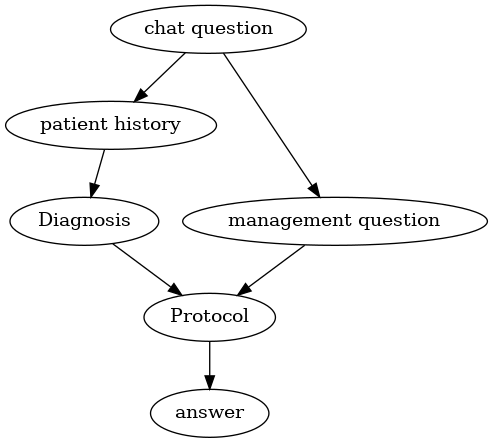

In [169]:
from IPython.display import Image, display

image_path = 'images/flowchart.png'
display(Image(filename=image_path))


In [182]:
chat_question = '''
A 45-year-old male patient was admitted to the ICU following a snake bite incident. The patient presented with symptoms including severe pain, localized swelling, and bruising at the site of the snake bite. Immediate first aid measures were administered, including immobilization of the affected limb and the application of a pressure immobilization bandage to minimize venom spread.
'''

In [183]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

from langchain.chains import SequentialChain

llm = ChatOpenAI(temperature=0)

# prompt template 1: find diagnosis
first_prompt = ChatPromptTemplate.from_template(
    "{Input}"
    "\n\nCan you give me a one word diagnosis for the patient from the above input"
)
# prompt template 2: identify protocol
protocols = {
    'Snake bite':'www.snakebite.com', 
    'Intracraneal bleed':'www.icbleed.com', 
    'Sepsis':'www.sepsis.com'
    }
first_prompt = ChatPromptTemplate.from_template(
    "{Diagnosis}"
    f"\n\nWhich of the following protocols fits the "
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="Diagnosis"
                    )


In [184]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one],
    input_variables=["Input"],
    output_variables=["Diagnosis"],
    verbose=True
)

In [185]:
langchain.debug=True

overall_chain(chat_question)

[chain/start] [1:chain:SequentialChain] Entering Chain run with input:
{
  "Input": "\nA 45-year-old male patient was admitted to the ICU following a snake bite incident. The patient presented with symptoms including severe pain, localized swelling, and bruising at the site of the snake bite. Immediate first aid measures were administered, including immobilization of the affected limb and the application of a pressure immobilization bandage to minimize venom spread.\n"
}
[chain/start] [1:chain:SequentialChain > 2:chain:LLMChain] Entering Chain run with input:
{
  "Input": "\nA 45-year-old male patient was admitted to the ICU following a snake bite incident. The patient presented with symptoms including severe pain, localized swelling, and bruising at the site of the snake bite. Immediate first aid measures were administered, including immobilization of the affected limb and the application of a pressure immobilization bandage to minimize venom spread.\n"
}
[llm/start] [1:chain:Sequenti

{'Input': '\nA 45-year-old male patient was admitted to the ICU following a snake bite incident. The patient presented with symptoms including severe pain, localized swelling, and bruising at the site of the snake bite. Immediate first aid measures were administered, including immobilization of the affected limb and the application of a pressure immobilization bandage to minimize venom spread.\n',
 'Diagnosis': 'Envenomation'}